# London Borough Recommender - Project Documentation

## Project Overview

The London Borough Recommender is a data-driven system designed to analyze various socio-economic factors across London boroughs and provide personalized borough recommendations based on user preferences. This project combines data cleaning, normalization, dimensionality reduction, clustering, and recommendation techniques to offer insights into London's boroughs and help users find areas that match their preferences.

## Key Components

1. Data Loading and Cleaning
2. Data Normalization and Dimensionality Reduction
3. Clustering
4. User Preference Generation
5. Borough Ranking and Recommendation

## Installing Libraries and Dependencies  

In [44]:
# Data handling and analysis
import numpy as np
import pandas as pd

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Geospatial data processing
import geopandas as gpd

# Machine learning and data processing
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score

# File operations
import os

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

### 1. load_clean_and_merge_data(filepath, map_filepath)

**Purpose:** Load, clean, and merge the borough data with geographical information.

**Rationale:**
- Data integration is crucial for combining socio-economic indicators with geographical data.
- Cleaning ensures consistency in borough names and removes unnecessary columns.
- Merging allows for spatial analysis and visualization of the data.

**Key steps:**
1. Load CSV data and set area name as index
2. Remove 'City of London' due to its unique administrative status
3. Load and clean geographical data from shapefile
4. Rename columns for clarity and consistency
5. Drop unnecessary columns

**Returns:** Cleaned DataFrame and GeoDataFrame


In [45]:
def load_clean_and_merge_data(filepath, map_filepath):
    """
    Load the CSV data and clean it by dropping unnecessary columns and renaming columns for clarity.
    
    Args:
    filepath (str): The path to the CSV file.
    map_filepath (str): The path to the shapefile.

    Returns:
    tuple: The cleaned DataFrame and the GeoDataFrame.
    """
    
    # Make area name the index
    df = pd.read_csv(filepath, index_col='Area')  
    df = df.drop('City of London', axis=0)

    map_df = gpd.read_file(map_file_path)
    map_df = map_df.set_index('NAME')
    map_df = map_df.drop('City of London', axis=0)
    
    # Sort the map_df's NAME alphabetically
    map_df = map_df.sort_values(by='NAME')
      
    df = df.rename(columns={
        'Poverty rate': 'PovertyRate',
        'Unemployment rate': 'UnemploymentRate',
        'Percentage of pupils who achieved grade 9-4': 'PupilsGrade9To4',
        'crime rates': 'CrimeRates',
        'average property price 2024 Feb': 'AvgPropertyPriceFeb2024',
        'Fair pay (London Living Wage)': 'LondonLivingWage',
        'Healthy Life Expentency': 'HealthyLifeExpectancy',
        'Green Space': 'GreenSpace',
        'Air Quality': 'AirQuality',
        'Carbon Emission': 'CarbonEmission',
        'Energy Efficiency': 'EnergyEfficiency',
        'Waste reduction': 'WasteReduction',
        'Being Ready for School': 'SchoolReadiness',
        'Good Qualification 16+': 'Qualification16Plus'
    })
    
    df = df.drop(columns=['AirQuality'])
    map_df = map_df.drop(columns=['SUB_2009', 'SUB_2006', 'GSS_CODE', 'ONS_INNER', 'NONLD_AREA', 'HECTARES'])
    
    return df, map_df


### normalize_data(dataframe)
**Purpose:** Standardize the data to ensure all features are on the same scale.

**Rationale:**
- Normalization is crucial when dealing with features of different scales (e.g., crime rates vs. property prices).
- Standardization (mean=0, std=1) helps in fair comparison and is often required for machine learning algorithms.

**Key steps:**
1. Use StandardScaler to transform the data

**Returns:** Scaled data and the scaler object

### 3. reduce_dimensionality(dataframe)

In [46]:
def normalize_data(dataframe):
  
    """
    Standardize the data and perform PCA for dimensionality reduction.
    
    Args:
    dataframe (pd.DataFrame): The input DataFrame to standardize and reduce.

    Returns:
    tuple: Scaler, PCA model, and the transformed DataFrame.
    """    
    #Normalize the data using StandardScaler
    scaler = StandardScaler()
    scaled_df = scaler.fit_transform(dataframe)
    
    return scaled_df, scaler

### reduce_dimensionality(dataframe)

**Purpose:** Perform Principal Component Analysis (PCA) to reduce the dimensionality of the data.

**Rationale:**
- PCA helps in reducing the number of features while retaining most of the variance in the data.
- Dimensionality reduction can help in visualization and can potentially improve clustering results.
- K means clustering is computed with two component so reducing the dimensionality is a must.

**Key steps:**
1. Apply PCA with 2 components
2. Transform the scaled data

**Returns:** PCA model and transformed data


In [47]:
def reduce_dimensionality(data):
  
    """
    Standardize the data and perform PCA for dimensionality reduction.
    
    Args:
    dataframe (pd.DataFrame): The input DataFrame to standardize and reduce.

    Returns:
    tuple: Scaler, PCA model, and the transformed DataFrame.
    """
    pca = PCA(n_components=2)
    pca_df = pca.fit_transform(data)
    
    return pca,pca_df

### generate_user_preference(dataframe)

**Purpose:** Generate random user preferences based on the range of numeric columns in the DataFrame.

**Rationale:**
- Simulating user preferences allows for testing and demonstration of the recommendation system.
- Using the actual data ranges ensures that generated preferences are realistic.

**Key steps:**
1. Identify numeric columns
2. Generate random values within the min-max range of each feature

**Returns:** Array of random user preferences


In [48]:
def generate_user_preference(dataframe):
    
    """
    Generate random user preferences based on the range of numeric columns in the DataFrame for a single user.
    
    Args:
    dataframe (pd.DataFrame): The input DataFrame.

    Returns:
    np.ndarray: An array of random user preferences.
    """
    
    numeric_columns = dataframe.select_dtypes(include=[np.number]).columns.tolist()
    min_values = dataframe[numeric_columns].min()
    max_values = dataframe[numeric_columns].max()
    user_preference = np.random.rand(1, len(numeric_columns)) * (max_values - min_values).values + min_values.values
    
    print(f"User Preferences: {np.round(user_preference, 2)}")
    
    return user_preference

### impute_missing_data(dataframe)

**Purpose:** Fill in missing values in the dataset.

**Rationale:**
- Missing data can significantly impact analysis and model performance.
- Mean imputation is a simple yet effective method for handling missing values in this context.
- Mean imputation for small number of null values

**Key steps:**
1. Use pandas' fillna method with mean values

**Returns:** DataFrame with imputed values

In [49]:
def impute_missing_data(dataframe):
  
    """
    Impute missing data in the DataFrame using Mean.
    
    Args:
    dataframe (pd.DataFrame): The input DataFrame with missing values.

    Returns:
    pd.DataFrame: The DataFrame with imputed values.
    """
    #Impute missing values with Mean
    imputed_df = dataframe.fillna(dataframe.mean())
    
        
    return imputed_df

### find_optimal_clusters(data, max_k=10)

**Purpose:** Use the Elbow Method to determine the optimal number of clusters.

**Rationale:**
- The Elbow Method helps in finding the point where adding more clusters doesn't significantly reduce inertia.
- This aids in choosing an appropriate number of clusters for K-Means.

### find_optimal_clusters_silhouette(data, max_k=10)

**Purpose:** Use the Silhouette Score to determine the optimal number of clusters.

**Rationale:**
- The Silhouette Score provides a measure of how similar an object is to its own cluster compared to other clusters.
- This method complements the Elbow Method in determining the optimal number of clusters.

In [50]:
# Elbow Method to find the optimal number of clusters
def find_optimal_clusters(data, max_k=10):
  """
  Use the Elbow Method to find the optimal number of clusters for KMeans.

  Args:
  data (np.ndarray): The input data for clustering.
  max_k (int): The maximum number of clusters to test.

  Returns:
  None
  """
  inertia = []
  K = range(1, max_k + 1)
  
  for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data)
    inertia.append(kmeans.inertia_)
  
  plt.figure(figsize=(10, 6))
  plt.plot(K, inertia, 'bo-')
  plt.xlabel('Number of clusters')
  plt.ylabel('Inertia')
  plt.title('Elbow Method For Optimal k')
  plt.show()

# Use the function to find the optimal number of clusters
#find_optimal_clusters(pca_df[['PC1', 'PC2']])

In [51]:

def find_optimal_clusters_silhouette(data, max_k=10):
  """
  Use the Silhouette Score to find the optimal number of clusters for KMeans.

  Args:
  data (np.ndarray): The input data for clustering.
  max_k (int): The maximum number of clusters to test.

  Returns:
  None
  """
  silhouette_scores = []
  K = range(2, max_k + 1)
  
  for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data)
    score = silhouette_score(data, kmeans.labels_)
    silhouette_scores.append(score)
  
  plt.figure(figsize=(10, 6))
  plt.plot(K, silhouette_scores, 'bo-')
  plt.xlabel('Number of clusters')
  plt.ylabel('Silhouette Score')
  plt.title('Silhouette Score For Optimal k')
  plt.show()

# Use the function to find the optimal number of clusters
#find_optimal_clusters_silhouette(pca_df[['PC1', 'PC2']])

### perform_clustering(data, num_clusters=5)

**Purpose:** Group similar boroughs together using K-Means clustering.

**Rationale:**
- Clustering helps identify boroughs with similar characteristics.
- K-Means is chosen for its simplicity and effectiveness in finding clusters in multidimensional data.

**Key steps:**
1. Apply K-Means algorithm with specified number of clusters
2. Fit the model and predict cluster labels

**Returns:** KMeans model and cluster labels

In [52]:
def perform_clustering(data, num_clusters=5):
  
    """
    Perform K-Means clustering on the data.
    
    Args:
    data (np.ndarray): The input data for clustering.
    num_clusters (int): The number of clusters for K-Means.

    Returns:
    tuple: KMeans model and cluster labels.
    """
    
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    
    clusters = kmeans.fit_predict(data)
    
    return kmeans, clusters

## Data Visualization

The project includes several visualization techniques:
- Pairplot and correlation heatmap for initial data exploration
- Scatter plot of PCA components to visualize clusters
- Choropleth map to display clusters geographically

In [54]:
def visualize_data(dataframe):
  
    """
    Visualize data distributions and correlations using seaborn and matplotlib.
    
    Args:
    dataframe (pd.DataFrame): The input DataFrame to visualize.
    """
    #Visualize data distributions
    plt.figure(figsize=(16, 6))
    sns.pairplot(dataframe)

    
    plt.figure(figsize=(16, 6))
    
    heatmap = sns.heatmap(dataframe.corr(), annot=True)
    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
    
    plt.show()

In [55]:
def save_transformed_data(data,folder_dir):
     # Ensure the transformed_data directory exists
     transformed_data_dir = os.path.join(folder_dir, "data\\transformed_data")
     os.makedirs(transformed_data_dir, exist_ok=True)

     # Save the transformed data
     data.to_csv(os.path.join(transformed_data_dir, "london_borough.csv"))

     print("Data saved successfully in the transformed_data folder.")

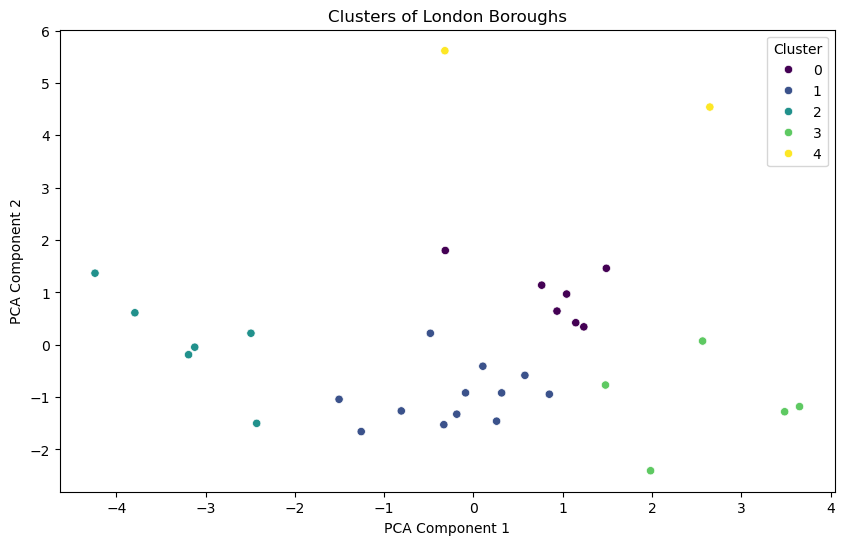

Data saved successfully in the transformed_data folder.


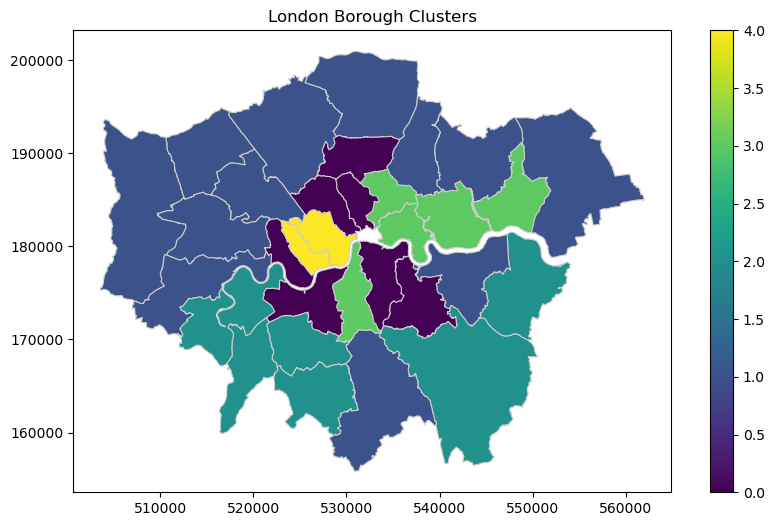

In [61]:
folder_dir = os.path.abspath(os.getcwd())
file_path = os.path.join(folder_dir, "data", "raw_data", "london_borough.csv")
map_file_path = os.path.join(folder_dir, "data", "raw_data", "statistical-gis-boundaries-london", "statistical-gis-boundaries-london", "ESRI", "London_Borough_Excluding_MHW.shp")

df, map_df = load_clean_and_merge_data(file_path, map_file_path)
imputed_df = impute_missing_data(df)
scaled_df, scaler = normalize_data(imputed_df)
pca, pca_df = reduce_dimensionality(scaled_df)
kmeans, clusters = perform_clustering(pca_df)

pca_df = pd.DataFrame(pca_df, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette="viridis", legend="full")
plt.title('Clusters of London Boroughs')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

merged = map_df.join(imputed_df)
merged['Cluster'] = clusters
save_transformed_data(merged, folder_dir)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
merged.plot(column='Cluster', cmap='viridis', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
plt.title('London Borough Clusters')
plt.show()